In [1]:
import pandas as pd
import os
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score 

In [177]:
def getData():
    cwd = os.getcwd()  #getting the path of this current program
    filename = cwd + '/default of credit card clients.xls'  #path + file
    
    np.random.seed(0)
    #Read file into pandas dataframe 
    nanDict= {}
    df = pd.read_excel('default of credit card clients.xls', header=1, skiprows=0, index_col=0, na_values=nanDict)
    df.rename(index=str, columns={'default payment next month': 'defaultPaymentNextMonth'}, inplace=True)

    #Drop the rows including data where parameters are out of range
    df=df.drop(df[df.SEX<1].index)
    df=df.drop(df[df.SEX<2].index)
    df=df.drop(df[(df.EDUCATION <1)].index)
    df=df.drop(df[(df.EDUCATION >4)].index)
    df=df.drop(df[df.MARRIAGE<1].index)
    df=df.drop(df[df.MARRIAGE>3].index)

    #Drop the rows for the customers that do not have any bills throughout the period as we do not want the model to train on this data
    df = df.drop(df[(df.BILL_AMT1 == 0) &
                (df.BILL_AMT2 == 0) &
                (df.BILL_AMT3 == 0) &
                (df.BILL_AMT4 == 0) &
                (df.BILL_AMT5 == 0) &
                (df.BILL_AMT6 == 0) &
                (df.PAY_AMT1 == 0) &
                (df.PAY_AMT2 == 0) &
                (df.PAY_AMT3 == 0) &
                (df.PAY_AMT4 == 0) &
                (df.PAY_AMT5 == 0) &
                (df.PAY_AMT6 == 0)].index)

    #Features and targets
    #.values returns a numpy representation of the DataFrame
    X= df.loc[:, df.columns != 'defaultPaymentNextMonth'].values 
    y= df.loc[:, df.columns == 'defaultPaymentNextMonth'].values
    
    # Categorical variables to one-hot's
    onehotencoder = OneHotEncoder(categories="auto")

    #OneHot encoder for column (2,3,5,6,7,8,9,10) [education,marriage, pay_april, pay_may, pay_jun, pay_jul, pay_aug, pay_sep]
    #Designmatrix, hotencoder on the categorical columns
    X = ColumnTransformer([('onehotencoder', onehotencoder, [2,3,5,6,7,8,9,10]),],remainder="passthrough").fit_transform(X)
    y = np.ravel(y)
    #print(y.shape)
    
    return X, np.ravel(y)

## Exploring the balance of the output classes

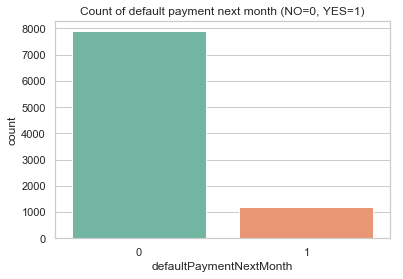

percentage of no default payment (NO=0) is 86.9632239594803
percentage of default payment (YES=1) is 13.03677604051971


In [178]:
import matplotlib.pyplot as plt
import seaborn as sns
#plot
sns.set(style="white")
sns.set(style="whitegrid")
sns.countplot(x='defaultPaymentNextMonth',data=df, palette='Set2')
plt.title('Count of default payment next month (NO=0, YES=1)')
plt.savefig('counter_plot_y.png', dpi=300)
plt.show()

#percentage calculation 
count_no_default = len(df[df['defaultPaymentNextMonth']==0])
count_default = len(df[df['defaultPaymentNextMonth']==1])
pct_of_no_default = count_no_default/(count_no_default+count_default)
print("percentage of no default payment (NO=0) is", pct_of_no_default*100)
pct_of_default = count_default/(count_no_default+count_default)
print("percentage of default payment (YES=1) is", pct_of_default*100)

We see from the above presentation that out classes are imbalanced, as our ratio of no default vs default payment is 79:21. We may stumble on some complications regaridng this imbalance as it is hard to train an a model on an imbalanced data set. Therefore, we should consider finding a way of balancing these out. Can do so by multplying the 'YES=1' gradient by some default (79/21).


Or, use some other way of evaluating the accuracy of the model.

## Fixing the imbalance in the data, scale and split into train and test data

In [183]:
X,y = getData()

#Fix the imbalance in the data 
ones_ = np.argwhere(y==1).flatten()
zeros_ = np.argwhere(y==0).flatten()


indexes = np.random.choice(zeros_,size=ones_.shape[0])
indexes = np.concatenate((indexes,ones_),axis=0)
y = y[indexes]
X = X[indexes]
indexes = np.arange(y.shape[0])
np.random.shuffle(indexes)
y = y[indexes]
X = X[indexes]


#print(np.mean(y == 1))

#Train-Test Split
trainingShare = 0.8 
seed = 1
X_train, X_test, y_train, y_test=train_test_split(X, y, train_size=trainingShare,
                                              test_size = 1-trainingShare,
                                              random_state=seed)



# Input Scaling
sc     = StandardScaler()
X_train = sc.fit_transform(X_train.todense())
X_test  = sc.transform(X_test.todense())

In [184]:
#print(np.sum(y_train)/len(y_train)) test that the length. ..

# Logistic Regression 


0.7049237778167163
[[2582  279]
 [1405 1441]]


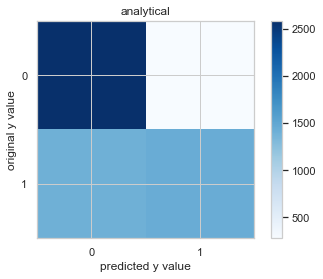

0.6846531184302733
[[628  78]
 [372 349]]


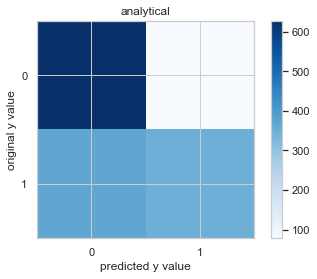

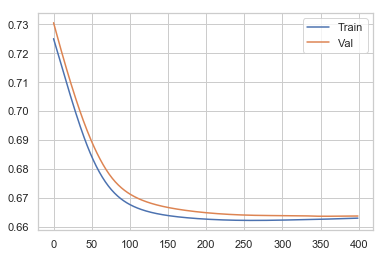

In [185]:
from sklearn.linear_model import LogisticRegression

import numpy as np
import matplotlib.pyplot as plt
from random import random, seed

from sklearn.metrics import confusion_matrix   #to evaluate the accuracy of a classification.


class LogisticRegression_class:

    def __init__(self, learning_rate, batch_size, n_epochs, lambda_=0, tol=1e-5):
        self.learning_rate = learning_rate
        #self.n_batches = n_batches
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.lambda_ = lambda_
        self.tol = tol



    def sigmoid_function(self,x):
        return(1/(1+np.exp(-x)))

    def gradient_descent(self, X, y,X_val,y_val):   #optimizing parameters beta
        #y = y[:, np.newaxis] 
        param = np.shape(X)[1] #number of parameters
        n = np.shape(X)[0] #number of rows
        n_batches = n // self.batch_size #integer division
        np.random.seed(42)
        beta = np.random.uniform(0.0,1.0, param)#np.random.randn(param)  #generate random initial values for beta


        error = []
        error_val = []
        #n_0_list = []
        #n_1 = np.count_nonzero(y)   #total number of y=1. double check that those are really 1.
        #const = (n - n_1)/n_1
        #print("*",X.shape, y.shape)
        
        index = np.arange(n)
        np.random.shuffle(index)
        batch_split = np.array_split(index,n_batches)
        
        
        k = 0
        #total numer of iterations:
        for i in range(self.n_epochs):
            y_pred = self.sigmoid_function(X @ beta)
            y_pred_val = self.sigmoid_function(X_val@beta)
            #print(y_pred.shape)
            C = self.cost_function(y, y_pred)
            C_val = self.cost_function(y_val,y_pred_val)
            #abs_C  = np.abs(C_data - C)
            error.append(C)
            #print("**", beta[0])
            error_val.append(C_val)

            for j in batch_split:
                #gradient  = np.sum(X.T * self.sigmoid_function(X @ beta) - y[:,np.newaxis]*X) #X.T @ (self.sigmoid_function(X @ beta) * const * y)
                gradient = np.sum ( X[j].T* (self.sigmoid_function(X[j]@beta)- y[j]),axis=1)
                
                gradient = gradient/y[j].shape[0]
                #print(gradient.shape)
                #learning_rate = self.learning_schedule(i*n_batches+j)     #adaptive learning rate. Sjekke om det enkelste funker forst.
                beta -= self.learning_rate * gradient
                k += 1
        
       
        self.beta = beta
        y_pred = self.sigmoid_function(X @ self.beta)
        tol = 0.5
        y_pred[y_pred >= tol] = 1
        y_pred[y_pred < tol] = 0
        y_pred_val[y_pred_val >= tol] = 1
        y_pred_val[y_pred_val < tol] = 0
        I = self.accuracy_function(y, y_pred)
        I_val = self.accuracy_function(y_val,y_pred_val)
        print(I)
        
        self.accuracy_matrix(y, y_pred, 'analytical')
        
        print(I_val)
        self.accuracy_matrix(y_val,y_pred_val,'analytical')

        return error, error_val, self.n_epochs

    def learning_schedule(self,t):  
        t0 = 5; t1 = 50
        return t0/(t+t1)

    def fit_function(self, X_train, X_test, y_train, y_test):
        self.gradient_descent(X_train, y_train)
        y_pred = X_test @ self.beta


    def predict_sklearn(self, X_train, X_test, y_train, y_test):
        LR = LogisticRegression()
        LR.fit(X_train,y_train)
        y_pred = LR.predict(X_test)
        v = np.count_nonzero(y_pred)
        I = self.accuracy_function(y_test, y_pred)
        C = self.cost_function(y_test, y_pred)
        CM = self.accuracy_matrix(y_test, y_pred, 'sklearn')

    def cost_function(self, y_data, y_pred):  #oppdatere parametrene.
        cost = -np.mean( (y_data.T * y_pred ) - np.log(1+np.exp(y_pred)))
        
        return cost
        #return -np.sum(y_data.T* np.log(y_pred) + (1-y_data.T)*np.log(1-y_pred))

    def accuracy_function(self,y_data, y_pred):  #hvor bra modellen gjor det.
        if np.shape(y_data)[0] == np.shape(y_pred)[0]:
            I = np.mean(y_data==y_pred)     ## =1 if y==y, 0 else.... np.mean #dobbelsjekk at det funker
        else:
            raise ValuError
        return I

    def accuracy_matrix(self, y_data, y_pred, title):
        fig, ax = plt.subplots()
        cm = confusion_matrix(y_data, y_pred)
        print(cm)
        cmap = plt.cm.Blues
        im = ax.imshow(cm, interpolation = 'nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        ax.set(xticks = np.arange(cm.shape[1]),
               yticks = np.arange(cm.shape[0]),
               title=title,
               xlabel='predicted y value',
               ylabel='original y value')
        plt.show()

        return cm




LogReg = LogisticRegression_class(learning_rate=0.001,batch_size=128, n_epochs=400, lambda_=0, tol=1e-5)
error_train,error_val, epochs = LogReg.gradient_descent(X_train, y_train, X_test, y_test)
#LogReg.predict_sklearn(X_train, X_test, y_train, y_test)
#Error, epochs = LogReg.gradient_descent(X_train, y_train)
#epochs = np.linspace(0,epochs, epochs)
plt.plot(range(epochs), error_train,label='Train')
plt.plot(range(epochs),error_val,label='Val')
plt.legend()
plt.show()
#print(XTrain.shape, yTrain.shape)

In [304]:
def tanh(x):
    return (np.exp(2*x)-1)/(np.exp(2*x)+1)

def neg_log(y_data, y_pred,deriv=False):
    if deriv:
        y_pred = y_pred.reshape(y_pred.shape[0],1)
        y_data = y_data.reshape(y_data.shape[0],1)
        return(y_pred-y_data)
    else:
        return -np.mean( (y_data.T * y_pred) - np.log(1+np.exp(y_pred)))

def sigmoid_function(x,deriv=False):
    if deriv:
        sig = 1/(1 + np.exp(-x))
        return(sig*(1 - sig))
    else:
        return(1/(1+np.exp(-x)))

## Neural Network
Testing full code for Neural Network, based on lecture notes 'Data Analysis and Machine Learning: Neural networks, from the simple perceptron to deep learning'

In [327]:


class Dense:
    def __init__(self,n_inputs,n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.w = np.random.randn(self.n_inputs,self.n_outputs)*np.sqrt(1/(n_inputs+n_outputs))
        self.b = np.zeros((1,self.n_outputs)) + 0.01
        
    def __call__(self,x):
        self.output = x@self.w + self.b
        return(self.output)


class NeuralNetwork:
    def __init__(self,layers, n_inputs, n_outputs,activation_function, cost_function):
        self.n_inputs         = n_inputs  #X-rows
        self.n_outputs       = n_outputs  #X-columns 
    
        self.act_func         = activation_function
        self.cost_func        = cost_function
        
        self.layers = [] 
        for i in range(len(layers)):
            self.layers.append(Dense(n_inputs,layers[i]))
            n_inputs = layers[i]
        self.layers.append(Dense(layers[-1],n_outputs))
        
        
    
    def feed_forward(self,X):
        #feed_forward training
        for layer in self.layers:
            X = self.act_func(layer(X))
        return(X)
        
    
    def backpropagation(self,X,y):
        # aL = self.feed-forward(x)
        y_pred = self.feed_forward(X)
        delta = self.cost_func(y,y_pred, deriv=True)*self.act_func(self.layers[-1].output, deriv=True) #delta^L
        delta = delta.T
        
        w_grad = []
        b_grad = []
        b_grad.append(np.sum(delta,axis=1))
        w_grad.append(delta@self.act_func(self.layers[-2].output))
        l = len(self.layers) - 1
        for layer in reversed(self.layers[:-1]):
            
            delta = self.layers[l].w@delta*self.act_func(self.layers[l-1].output,deriv=True).T
            b_grad.append(np.sum(delta,axis=1))  #tror sum over en av aksene
            if l==1:
                a = X
            else:
                a = self.act_func(self.layers[l-2].output)
            w_grad.append(delta@a)
            l-=1
            
        w_grad = list(reversed(w_grad))
        b_grad = list(reversed(b_grad))
        
        return(w_grad,b_grad)
    
    def train(self,X,y,lr,batch_size,epochs):
        data_ind = np.arange(X.shape[0])
        iterations = X.shape[0] // batch_size
        for i in range(epochs):
            for j in range(iterations):
                #pick datapoints with replacements
                chosen_datapoints = np.random.choice(data_ind, size=batch_size, replace=False)
                
                #minibatch training data
                X_full = X[chosen_datapoints]
                y_full = y[chosen_datapoints]
            
                w_grad,b_grad = self.backpropagation(X_full,y_full)
                
                for i, layer in enumerate(self.layers): #update grad des
                    layer.w -= lr*w_grad[i].T/batch_size
                    layer.b -= lr*b_grad[i].reshape(-1,b_grad[i].shape[0])/batch_size
        
            y_pred = self.feed_forward(X)
            print(self.cost_func(y,y_pred))
                       

In [331]:
layers = [20,10]
n_inputs = X.shape[1]
n_outputs = 1
activation_function = sigmoid_function
cost_function = neg_log
lr = 1e-2
batch_size= 128
NN = NeuralNetwork(layers, n_inputs, n_outputs,activation_function, cost_function)
#x=np.linspace(-10,10,10)
epochs=1000
NN.train(X,y,lr,batch_size,epochs)

0.7385494289277825
0.7362866712112188
0.7347903504501975
0.733355550887177
0.7321598351396598
0.7318285233302625
0.7313163152663748
0.7305590883058942
0.7295184552243859
0.7290711918747015
0.7283402573452643
0.727751856143163
0.7272244398203682
0.726765033692944
0.7264833911701382
0.7261888607407125
0.7258925682289971
0.7256911185778805
0.725346976534048
0.7250979378745168
0.7249873476125354
0.7246629368588354
0.7245894398100223
0.7244483450905543
0.7243166457782921
0.7243390400520143
0.7242503553630154
0.724312998558622
0.7243486667517899
0.7243639474290744
0.7244377652350358
0.7243891617606005
0.7243652632253943


KeyboardInterrupt: 